
# Оптимизация: градиентный спуск, метод Ньютона, SGD


<style>
.reveal .slides section {
    height: 100% !important;
    overflow-y: auto;
}
</style>



## План
1. Повторение: градиенты, матрицы Гессе, выпуклость
2. Градиентный спуск (GD)
3. Метод Ньютона
4. Стохастический градиентный спуск (SGD) и моментум
5. Демонстрации и сравнения
6. Упражнения


In [1]:

import math
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

def line_plot(x, y, xlabel, ylabel, title):
    plt.figure() # 
    plt.plot(x, y) # x vs y
    plt.xlabel(xlabel) 
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

def overlay_plot(series_list, xlabel, ylabel, title):
    plt.figure()
    for x, y, label in series_list:
        plt.plot(x, y, label=label)
    plt.xlabel(xlabel); plt.ylabel(ylabel); plt.title(title)
    plt.legend()
    plt.show()



## Теория

### Градиенты, гессианы, выпуклость
- Градиент $ \nabla f(x) $ указывает направление наибольшего возрастания; для спуска берём $ -\nabla f(x) $.
- Гессиан $ \nabla^2 f(x) $ описывает локальную кривизну.


## Методы оптимизации

### Нормальное уравнение (аналитическое решение для линейной регрессии)
Для задачи наименьших квадратов можно явно найти оптимальные веса:
$$ w^* = (X^{\top} X)^{-1} X^{\top} y. $$
На практике применяем `np.linalg.solve`, чтобы не строить обратную матрицу, но идея та же: решаем систему размера $d \times d$ один раз.


In [2]:
# X, y
#w = np.linalg.solve(X.T @ X) @ X.T @ y


**Почему в современной ML это используют редко:**
- Построение $X^{\top} X$ и решение системы стоит $\mathcal{O}(d^3)$ по времени и $\mathcal{O}(d^2)$ по памяти — дорого при большом числе признаков $d$.
- При сильной коррелированности признаков или $d > n$ матрица становится вырожденной/плохо обусловленной, и решение нестабильно без регуляризации.
- Метод предполагает, что весь датасет помещается в память и не поддерживает инкрементальные обновления, поэтому плохо подходит для потоковых или огромных данных.
- Он работает только для квадратичной ошибки; для логистической регрессии и других моделей закрытой формы нет.



### Градиентный спуск (GD)
Обновление:  
$$
x_{t+1} = x_t - \alpha \nabla f(x_t).
$$


In [11]:
def run_gd_1d(grad, x0, alpha, iters, clip=None):
    x = float(x0)
    xs, fs = [x], []
    for _ in range(iters):
        g = grad(x)
        if clip is not None:
            g = np.clip(g, -clip, clip)
        x = x - alpha * g
        
        xs.append(x)
    return np.array(xs)
        

**Формула для 1D градиентного спуска**
$$ x_{t+1} = x_t - \alpha f'(x_t). $$
Здесь $\alpha$ — шаг обучения, а $f'(x_t)$ — производная функции в точке $x_t$.



### Метод Ньютона
Обновление учитывает кривизну:  
$$
x_{t+1} = x_t - \bigl[\nabla^2 f(x_t)\bigr]^{-1} \nabla f(x_t).
$$
Квадратичная сходимость рядом с минимумом, если гессиан $ \succ 0 $ и начальная точка достаточно близка.

Для квадратичной функции $ f(x)=\tfrac12 x^\top Q x + b^\top x + c $ с $Q\succ 0$ достаточно одного шага до минимума.


In [4]:
def run_newton_1d(grad, hess, x0, iters, damping=0.0):
    """
    grad : function that returns gradient of some f(x)
    hess : function that returns hessian of some f(x)
    """
    x = float(x0)
    xs, fs = [x], []
    for _ in range(iters):
        g = grad(x)
        h = hess(x)
        x = x - g / h
        xs.append(x)
    return np.array(xs)

**Формула для шага метода Ньютона**
$$ x_{t+1} = x_t - [ f''(x_t) ]^{-1} f'(x_t). $$
Демпфирование масштабирующее шаг можно записать как $x_{t+1} = x_t - \tfrac{1}{1+\lambda} [f''(x_t)]^{-1} f'(x_t)$ при параметре $\lambda$.



### Стохастический градиентный спуск (SGD)
Для эмпирического риска $ f(x)=\tfrac1N \sum_{i=1}^N \ell(x; z_i) $ используем стохастическую оценку:  
$$
x_{t+1} = x_t - \alpha_t \,\widehat{\nabla} f(x_t), \quad \mathbb{E}[\widehat{\nabla} f]=\nabla f.
$$
При уменьшающихся шагах $ \alpha_t $ SGD сходится в выпуклых задачах; моментум снижает дисперсию и ускоряет движение по узким долинам.


In [5]:
def run_sgd_1d(grad, x0, alpha=0.1, iters=30, batch_grad_fn=None, clip=1e3):
    xs = [x0]
    for _ in range(iters):
        g = batch_grad_fn(xs[-1])
        x_new = xs[-1] - alpha*g
        xs.append(x_new)
    return np.array(xs)


**Формула для 1D SGD**
$$ x_{t+1} = x_t - \alpha \widehat{f}'(x_t). $$
Здесь $\widehat{f}'(x_t)$ — стохастическая оценка производной, вычисленная по мини-батчу.


## Демо 1: градиентный спуск в 1D — влияние шага
Функции:
- $f_1(x)=x^2$ с $\nabla f_1=2x$
- $f_2(x)=x^3$ с $\nabla f_2=3x^2$

Сравниваем два шага на выпуклой квадратичной функции, затем повторяем на кубике, чтобы увидеть влияние кривизны и седел.


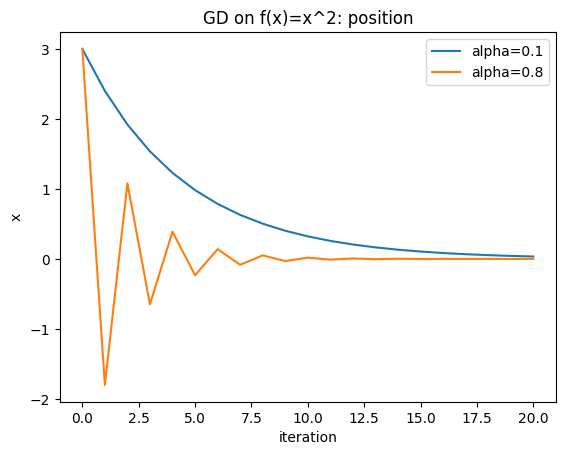

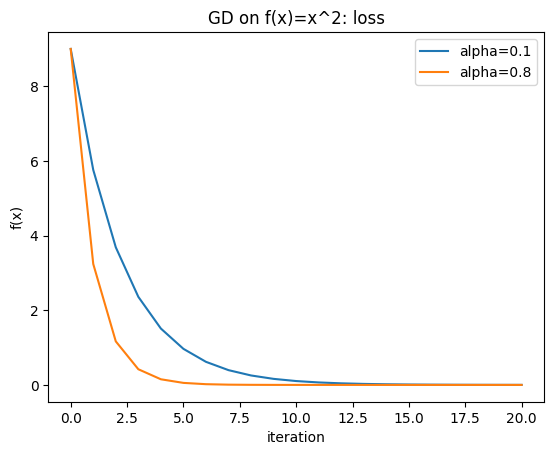

In [12]:
# Настраиваем квадратичную функцию потерь: определяем цель и градиент
def f1(x): return x**2
def g1(x): return 2*x

# Кубическая функция для последующего сравнения
def f2(x): return x**3
def g2(x): return 3*(x**2)

x0 = 3.0
iters = 20

# Отслеживаем траектории ГС для двух шагов на квадратичной функции
xs_a = run_gd_1d(g1, x0, alpha=0.1, iters=iters)
xs_b = run_gd_1d(g1, x0, alpha=0.8, iters=iters)

# Строим зависимость положения от итерации
overlay_plot(
    [
        (np.arange(len(xs_a)), xs_a, "alpha=0.1"),
        (np.arange(len(xs_b)), xs_b, "alpha=0.8"),
    ],
    xlabel="iteration", ylabel="x", title="GD on f(x)=x^2: position"
)

# Строим зависимость значения функции от итерации
fa = [f1(x) for x in xs_a]
fb = [f1(x) for x in xs_b]
overlay_plot(
    [
        (np.arange(len(fa)), fa, "alpha=0.1"),
        (np.arange(len(fb)), fb, "alpha=0.8"),
    ],
    xlabel="iteration", ylabel="f(x)", title="GD on f(x)=x^2: loss"
)


**Интерпретация запусков для $f(x)=x^2$**
- `alpha=0.1` устойчиво тянет точку к нулю, поэтому положение и значение функции убывают гладко.
- `alpha=0.8` движется быстрее, но перелетает минимум, из-за чего кривые колеблются, прежде чем стабилизироваться.


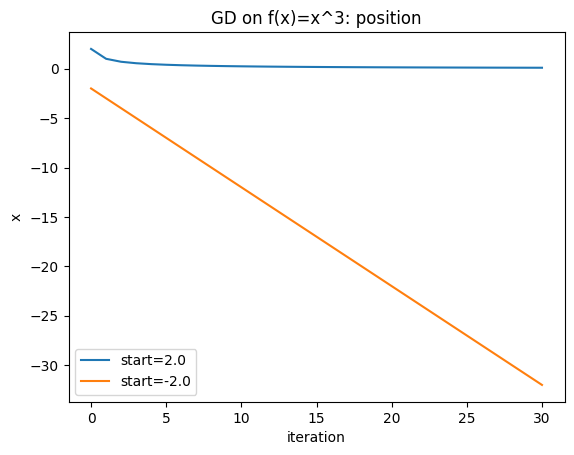

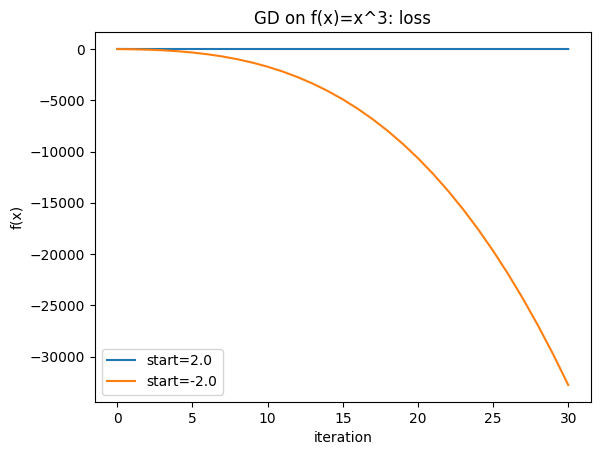

In [15]:
# Поведение на f(x)=x^3: градиент почти нулевой около 0 при x>=0
xs_c = run_gd_1d(g2, x0=2.0, alpha=0.1, iters=30, clip = 10)
xs_d = run_gd_1d(g2, x0=-2.0, alpha=0.1, iters=30, clip = 10)

# Сравниваем, как старт по разные стороны седла меняет траекторию
overlay_plot(
    [
        (np.arange(len(xs_c)), xs_c, "start=2.0"),
        (np.arange(len(xs_d)), xs_d, "start=-2.0"),
    ],
    xlabel="iteration", ylabel="x", title="GD on f(x)=x^3: position"
)

# Отслеживаем значение цели, чтобы показать медленный прогресс в плоских областях
fc = [f2(x) for x in xs_c]
fd = [f2(x) for x in xs_d]
overlay_plot(
    [
        (np.arange(len(fc)), fc, "start=2.0"),
        (np.arange(len(fd)), fd, "start=-2.0"),
    ],
    xlabel="iteration", ylabel="f(x)", title="GD on f(x)=x^3: loss"
)


**Интерпретация запусков для $f(x)=x^3$**
- При старте `x0=2.0` траектория замирает около 0: градиент выравнивается, и прогресс сильно замедляется.
- При старте `x0=-2.0` отрицательный наклон кубической функции уводит точку из седла гораздо быстрее.


## Демо 2: метод Ньютона в 1D
- Квадратичная функция: один шаг благодаря постоянному гессиану.
- Невыпуклая квартичная функция: знак кривизны меняется; демпфирование стабилизирует шаги.

Сначала решаем простую квадратичную задачу, чтобы показать скорость Ньютона, затем смотрим, как демпфирование спасает метод при отрицательном гессиане.


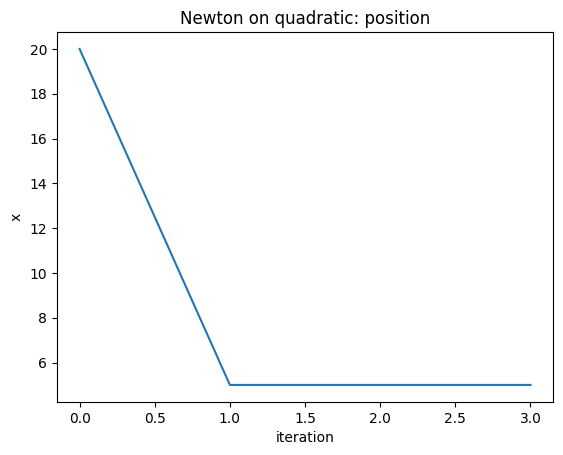

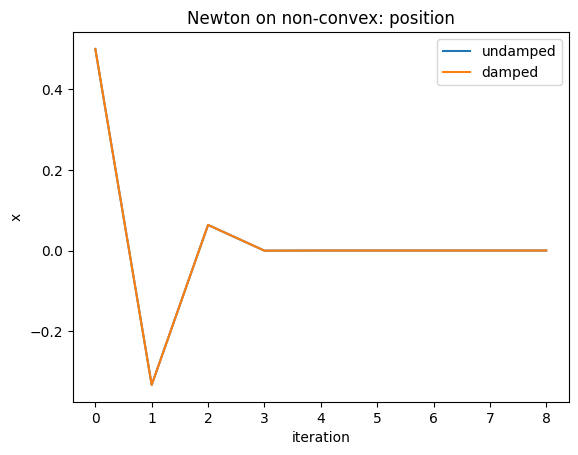

In [16]:
# Квадратичная f(x) = (x-5)^2 => grad=2(x-5), hess=2
def fq(x): return (x-5.0)**2
def gq(x): return 2*(x-5.0)
def hq(x): return 2.0

# Один шаг Ньютона попадает точно в минимум
xs_q = run_newton_1d(gq, hq, x0=20.0, iters=3)
line_plot(np.arange(len(xs_q)), xs_q, "iteration", "x", "Newton on quadratic: position")

# Невыпуклая f(x) = x^4 - 3x^2 + 2
def fn(x): return x**4 - 3*(x**2) + 2.0
def gn(x): return 4*(x**3) - 6*x
def hn(x): return 12*(x**2) - 6

# Сравниваем шаги Ньютона без демпфирования и с демпфированием
xs_n1 = run_newton_1d(gn, hn, x0=0.5, iters=8, damping=0.0)
xs_n2 = run_newton_1d(gn, hn, x0=0.5, iters=8, damping=1.0)  # демпфирование

overlay_plot(
    [
        (np.arange(len(xs_n1)), xs_n1, "undamped"),
        (np.arange(len(xs_n2)), xs_n2, "damped"),
    ],
    "iteration",
    "x",
    "Newton on non-convex: position",
)


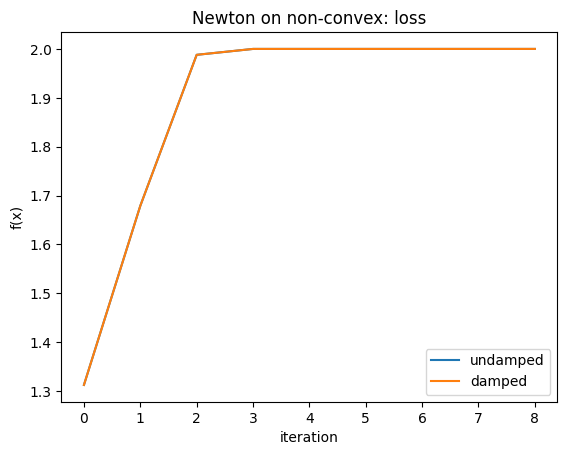

In [17]:
# Строим значения целевой функции для невыпуклого случая
def seq_vals(xs, f):
    return [f(x) for x in xs]

# Вычисляем значения квартичной функции на каждой траектории, чтобы подчеркнуть эффект демпфирования
ys1 = seq_vals(xs_n1, fn)
ys2 = seq_vals(xs_n2, fn)

overlay_plot(
    [
        (np.arange(len(ys1)), ys1, "undamped"),
        (np.arange(len(ys2)), ys2, "damped"),
    ],
    "iteration",
    "f(x)",
    "Newton on non-convex: loss",
)


**Интерпретация графиков метода Ньютона**
- На квадратичной функции Ньютон одним шагом попадает в минимум, поэтому график положения сразу падает к оптимуму.
- Для невыпуклой квартичной функции траектория без демпфирования вылетает из области положительной кривизны и колеблется, тогда как демпфирование делает шаги осторожными и обеспечивает монотонное уменьшение потерь.


## Демо 4: бинарная логистическая регрессия — GD vs mini-batch SGD

Датасет: синтетический 2D. Мы отслеживаем потерю по итерациям для двух оптимизаторов и смотрим на получившуюся границу.

Шаги:
1. Сгенерировать два гауссовых кластера и добавить столбец смещения.
2. Обучить логистическую регрессию полным GD и мини-батчевым SGD.
3. Сравнить кривые потерь и визуализировать границу решений мини-батчевого SGD.


In [19]:
# Генерируем разделимые гауссовы кластеры для бинарной задачи
def make_logreg_data(n_samples=600):
    """Создаём два гауссовых кластера для бинарной классификации."""
    half = n_samples // 2
    class_one = np.random.randn(half, 2) + np.array([1.5, 1.0])
    class_zero = np.random.randn(half, 2) + np.array([-1.5, -1.0])
    X = np.vstack([class_one, class_zero])
    y = np.hstack([np.ones(half), np.zeros(half)])
    return X, y

**Формулы для вспомогательных функций**
- Добавление смещения: $$X_b = [\,X\; \mathbf{1}\,]$$.
- Сигмоида: $$\sigma(z) = \frac{1}{1 + e^{-z}}$$.
- Потеря:
$$
L(w)=-\frac{1}{N}\Big[y^{\top}\log(\sigma(Xw))+( \mathbf{1}-y)^{\top}\log\big(\mathbf{1}-\sigma(Xw)\big)\Big]
$$
- Градиент: $$\nabla L(w) = \frac{1}{N} X^\top (\sigma(X w) - y)$$.


In [21]:
# Добавляем к признакам столбец со свободным членом
def add_bias_column(X):
    """Добавляем к X столбец единиц для свободного члена."""
    ones = np.ones((X.shape[0], 1))
    return np.hstack([X, ones])

def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

def logistic_loss(w, X, y, reg=0.0):
    """Вычисляем логистическую функцию потерь."""
    scores = X @ w
    probs = sigmoid(scores)
    lw = y.T @ np.log(probs) + (1 - y).T @ np.log(1 - probs)
    lw = -np.mean(lw)
    return float(lw)
    

def logistic_grad(w, X, y, reg=0.0):
    """Вычисляем градиент логистической функции потерь."""
    scores = X@w
    probs = sigmoid(scores)
    glw = np.mean(X.T @ (probs - y))
    return glw


In [23]:
# Создаём данные один раз, чтобы все методы работали с одной выборкой
X, y = make_logreg_data()
X_with_bias = add_bias_column(X)  # исходный X нужен для отрисовки границы

X_with_bias

array([[ 0.77826245,  1.17682087,  1.        ],
       [ 0.95331992,  0.72834489,  1.        ],
       [ 3.17345209,  2.34046105,  1.        ],
       ...,
       [-0.24076676,  0.14644087,  1.        ],
       [-2.47337884,  0.00713334,  1.        ],
       [-1.16385504, -1.22747626,  1.        ]], shape=(600, 3))

In [24]:
# Базовый полно-батчевый градиентный спуск
def gradient_descent_logreg(X, y, num_steps=200, lr=0.5, reg=0.0):
    """Полно-батчевый градиентный спуск для логистической регрессии."""
    # w1 * traing
    w = np.zeros(X.shape[1])
    loss_history = []
    for step in range(num_steps):
        loss = logistic_loss(w, X, y)
        grad = logistic_grad(w, X, y)
        w -= lr * grad
        loss_history.append(loss)
    return w, np.array(loss_history)


**Формула для полно-батчевого GD по логистической потере**
$$ w_{t+1} = w_t - \eta \left[ \frac{1}{N} X^\top (\sigma(X w_t) - y) \right]. $$
Здесь $\sigma(z)=1/(1+e^{-z})$, $\eta$ — шаг обучения, $N$ — число объектов


In [ ]:
def mini_batch_sgd_logreg(
    X, y, num_steps=2000, step_size=0.05, batch_size=16, reg=0.0
):
    """Мини-батчевый SGD без момента."""
   


**Формула для mini-batch SGD**
$$ w_{t+1} = w_t - \eta \, g_t, \quad g_t = \frac{1}{B} X_B^\top (\sigma(X_B w_t) - y_B) + \lambda w_t. $$
Здесь $B$ — размер мини-батча, а $\eta$ — шаг обучения.


In [ ]:
# Общие гиперпараметры для всех оптимизаторов
gd_config = dict(num_steps=200, step_size=0.5, reg=1e-3)
sgd_config = dict(num_steps=2000, step_size=0.05, batch_size=16, reg=1e-3)

# Обучаем два варианта на одних и тех же данных
w_gd, loss_gd = gradient_descent_logreg(X_with_bias, y, **gd_config)
w_sgd, loss_sgd = mini_batch_sgd_logreg(X_with_bias, y, **sgd_config)

# Накладываем кривые потерь, чтобы сравнить скорость сходимости
overlay_plot(
    [
        (np.arange(loss_gd.size), loss_gd, "GD"),
        (np.arange(loss_sgd.size), loss_sgd, "SGD (mini-batch 16)"),
    ],
    "iteration",
    "loss",
    "Logistic regression: GD vs mini-batch SGD",
)


**Интерпретация кривых потерь**
- `GD` плавно уменьшает потерю и требует меньше итераций, потому что на каждом шаге использует весь датасет.
- `SGD (mini-batch 16)` подёргивается вокруг оптимума: шумные оценки градиента вызывают колебания, хотя тренд направлен вниз.


In [ ]:
# Визуализируем границу решений для мини-батчевого SGD
def plot_boundary(X, y, w):
    """Строим границу решений логистической модели при вероятности 0.5."""
    plt.figure()
    plt.scatter(X[y==0, 0], X[y==0, 1], s=10)
    plt.scatter(X[y==1, 0], X[y==1, 1], s=10)
    xx = np.linspace(X[:, 0].min() - 1, X[:, 0].max() + 1, 200)
    yy = np.linspace(X[:, 1].min() - 1, X[:, 1].max() + 1, 200)
    XX, YY = np.meshgrid(xx, yy)
    grid = np.c_[XX.ravel(), YY.ravel(), np.ones(XX.size)]
    Z = sigmoid(grid @ w).reshape(XX.shape)
    plt.contour(XX, YY, Z, levels=[0.5])
    plt.title("Decision boundary (p=0.5)")
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.show()

# Используем веса мини-батчевого SGD
plot_boundary(X, y, w_sgd)


**Интерпретация границы решений**
- Тёмный контур соответствует $p(y=1|x)=0.5$, поэтому точки выше отделяются как класс 1.
- Прямая чисто разделяет два гауссовых облака, что означает, что логистическая модель выучила линейный разделитель.
- Небольшое перекрытие в центре напоминает: шумные объекты могут остаться по неправильную сторону даже после сходимости.



## Упражнения
1. **Поиск шага:** реализуйте обратный линейный поиск для GD на $x^3$ и сравните с фиксированными шагами.
2. **Предобусловливание:** для 2D-квадратичной функции отмасштабируйте координаты и покажите улучшенный путь ГС.
3. **Страховка Ньютона:** добавьте проверку, переключающуюся на ГС, когда гессиан $\preceq 0$.
4. **Расписание SGD:** попробуйте $\alpha_t = \alpha_0 / \sqrt{t}$. Сравните шум и скорость.
5. **Настройка момента:** изменяйте $\beta \in \{0.5, 0.9, 0.99\}$. Посчитайте итерации до потери $< 0.1$.



## Приложение: ключевые формулы и скорости
- ГС: $ x_{t+1} = x_t - \alpha \nabla f(x_t) $. Для сильно выпуклых задач скорость $ \mathcal{O}((1-\mu/L)^t) $.
- Ньютон: $ x_{t+1}=x_t - [\nabla^2 f(x_t)]^{-1}\nabla f(x_t) $. Квадратичная сходимость возле оптимума.
- SGD: $ x_{t+1}=x_t - \alpha_t \widehat{\nabla} f(x_t) $. При убывающих шагах сходится в выпуклых задачах.
- Моментум: $ v_{t+1}=\beta v_t + \nabla f(x_t) $, $ x_{t+1}=x_t-\alpha v_{t+1} $.
